In [1]:
from learning_models import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

1 Exploratory Data Analysis
================

In [2]:
df = pd.read_csv('winequality-white.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


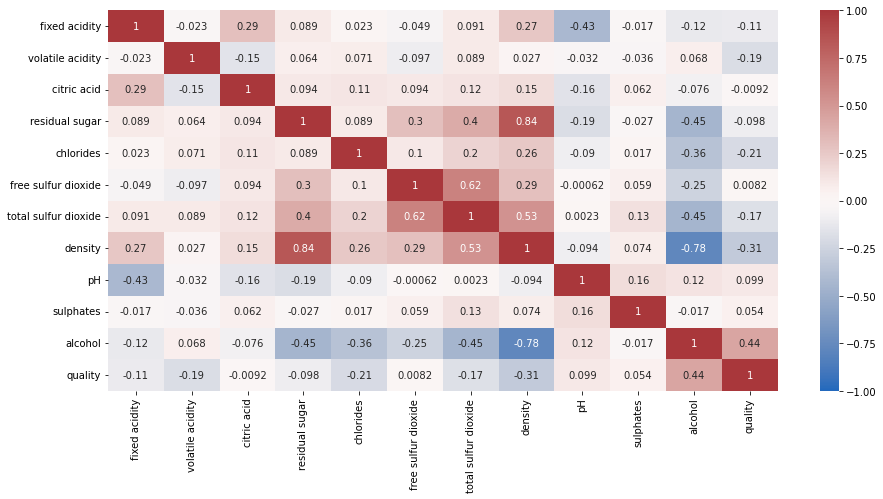

In [4]:
#Show the correlation between attributes
#high correlated attributes can be removed if overfitting occurs in the model building later on - residual sugar and density？total and free sulfur dioxide
white = df.copy()
plt.figure(figsize=(15,7))
sns.heatmap(white.corr(),vmin=-1,vmax=1,annot=True,cmap='vlag')
plt.show()

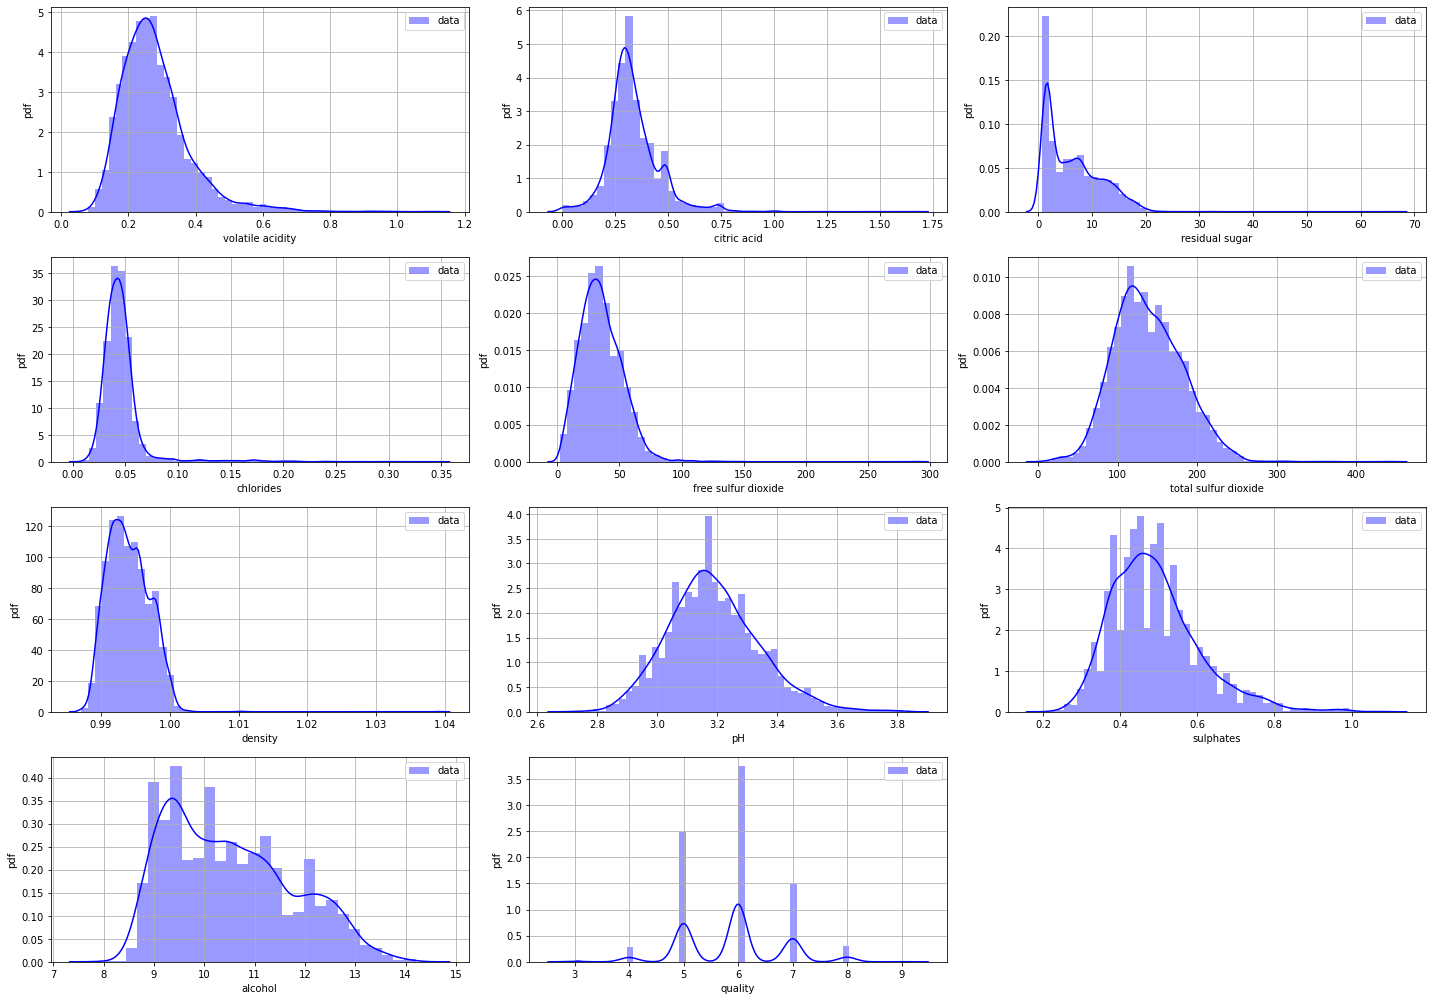

In [5]:
plt.figure(figsize=(20,14))
for i, col in enumerate(list(df.iloc[:,1:].columns.values)):
    plt.subplot(4,3,i+1)
    sns.distplot(white[col],color='b',kde=True, label='data')
    plt.ylabel('pdf')
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()

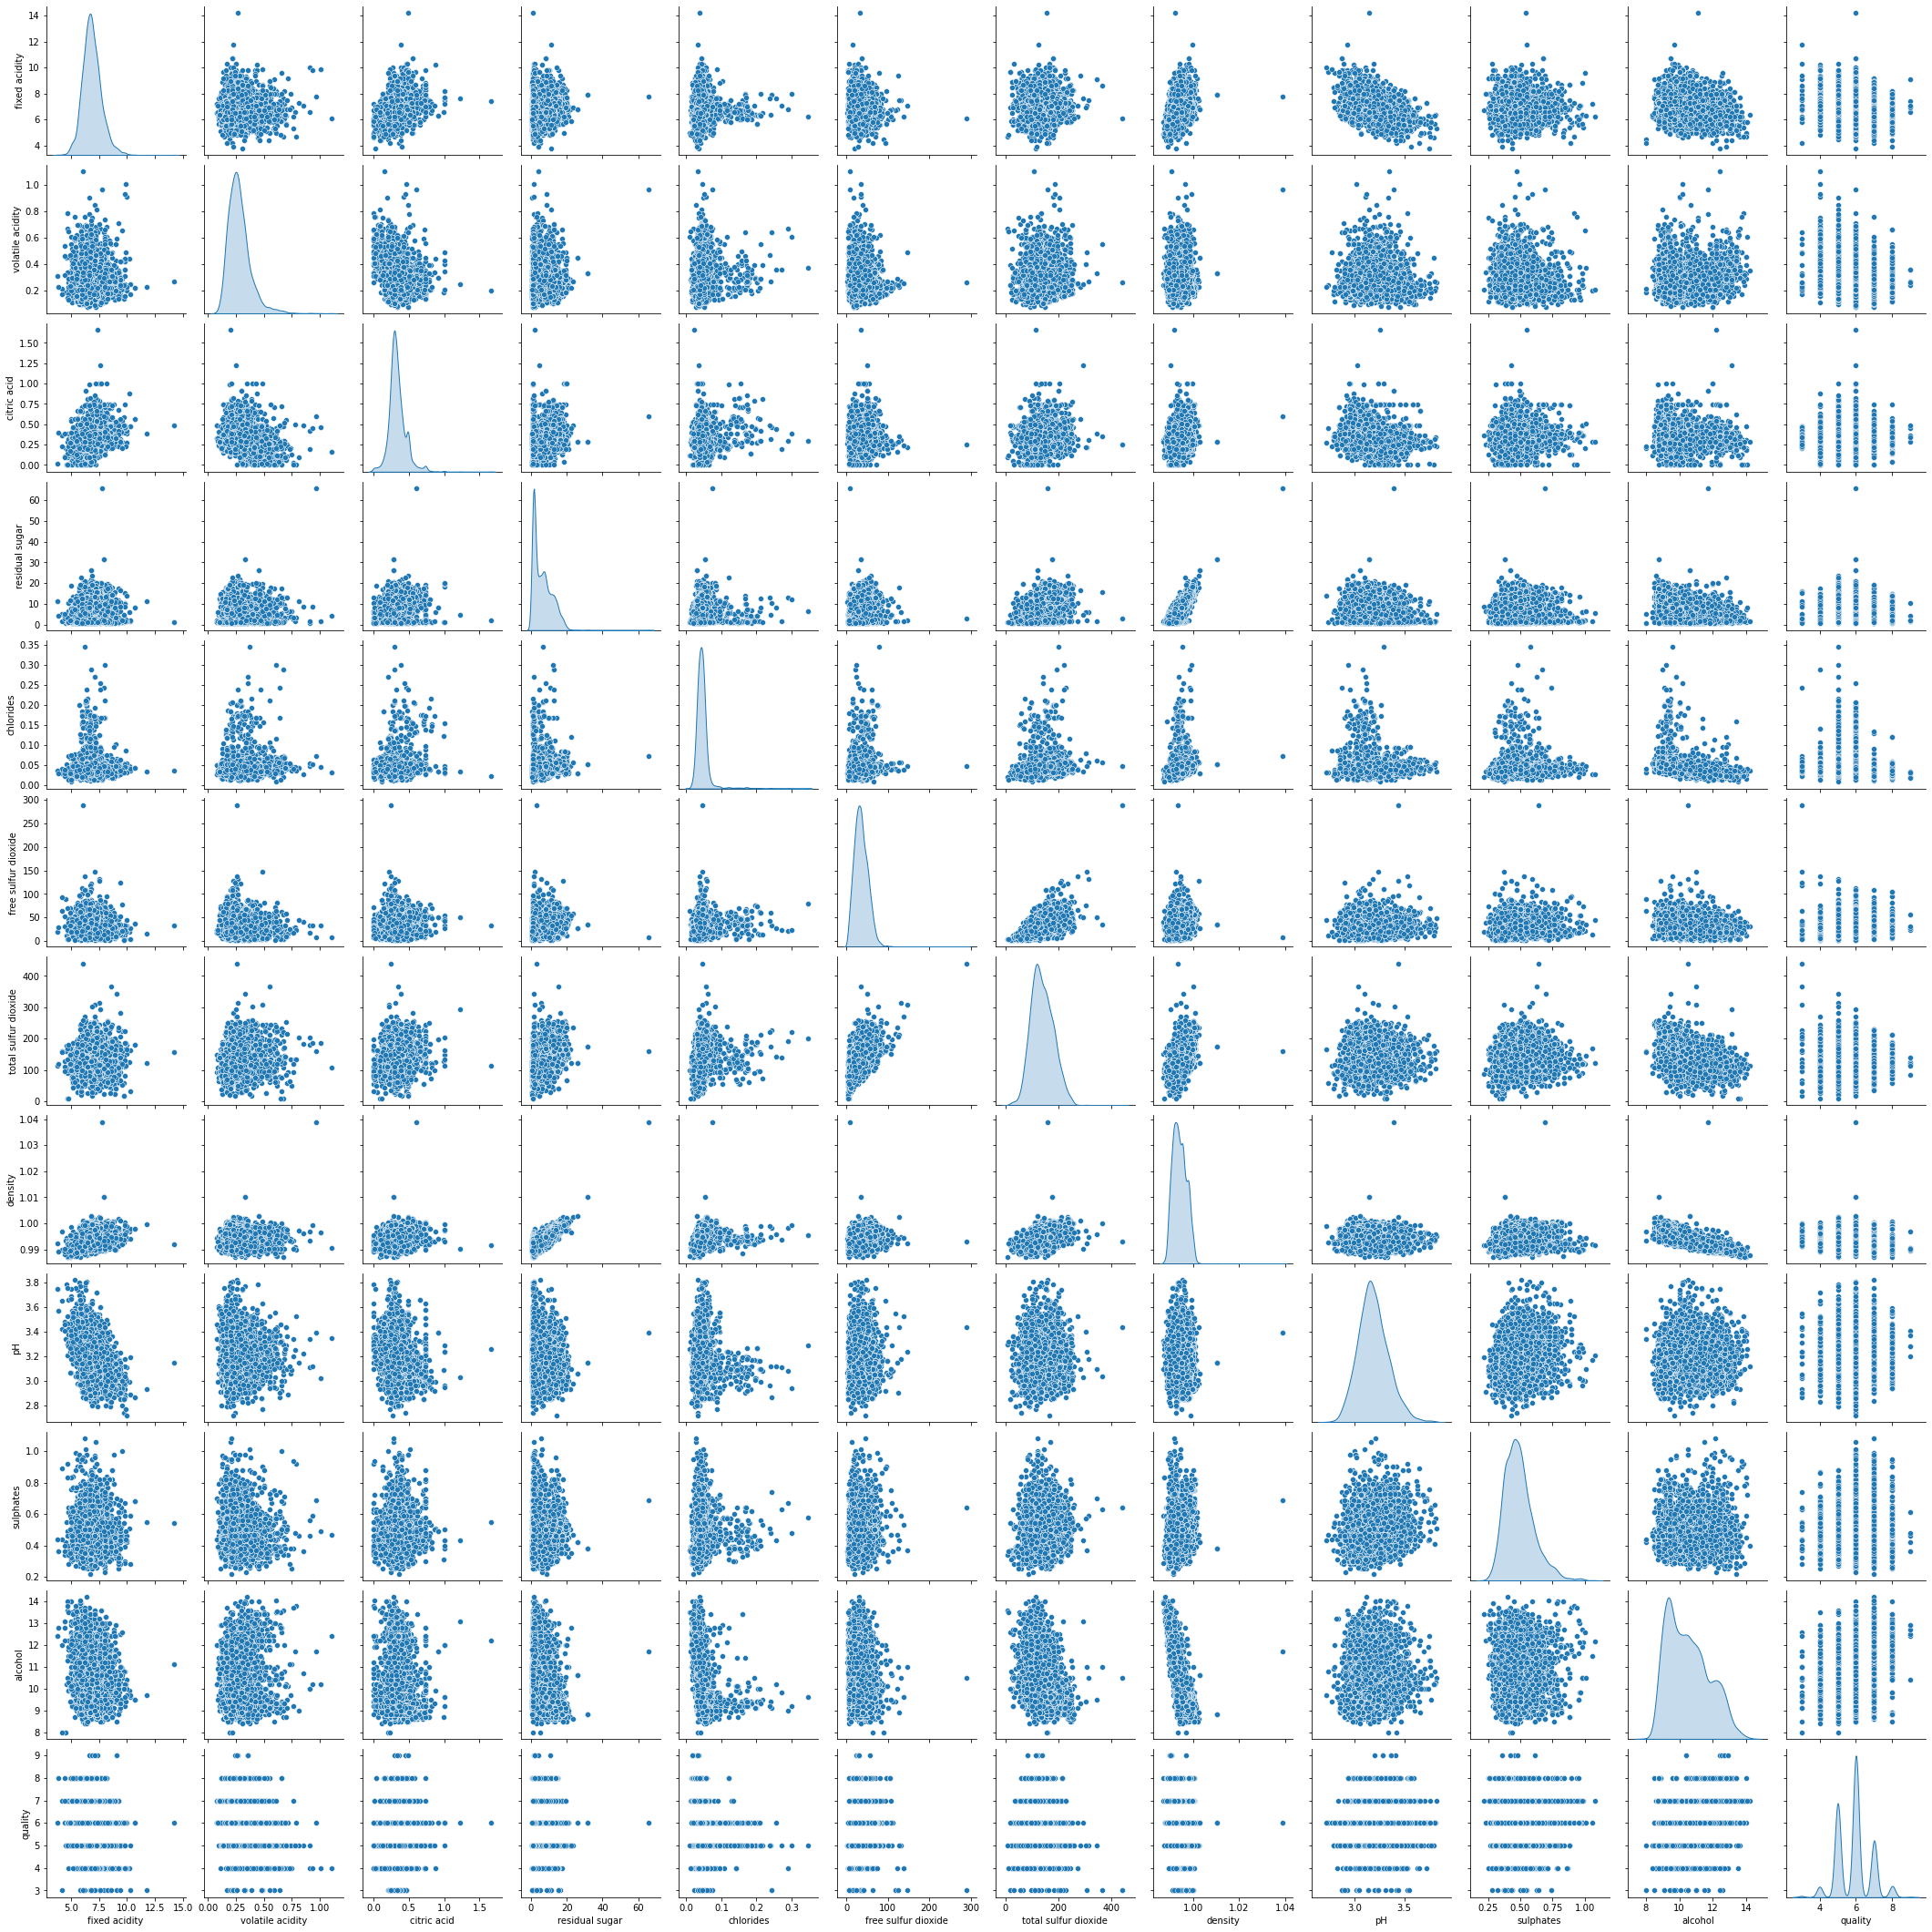

In [6]:
sns.pairplot(white,kind="scatter",diag_kind="kde")

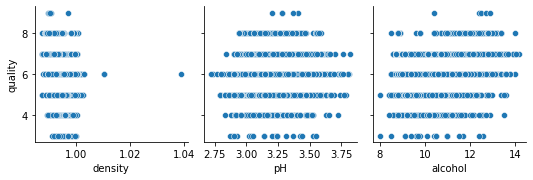

In [7]:
sns.pairplot(white,x_vars=['density','pH','alcohol'],y_vars=['quality'],kind="scatter",diag_kind="kde")

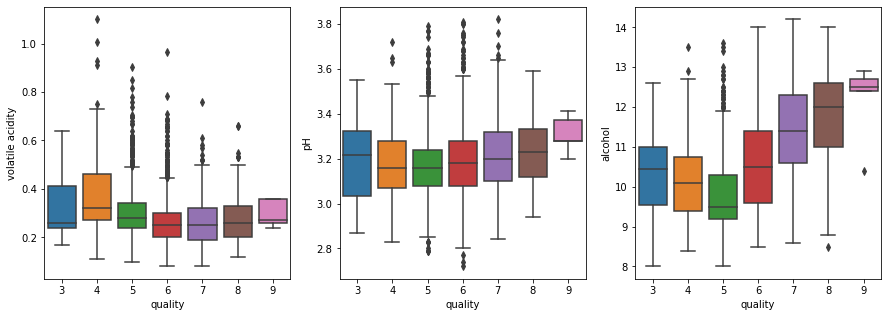

In [8]:
feature_ticks = ['volatile acidity','pH','alcohol']
plt.figure(figsize=(15,5))
for i in range(len(feature_ticks)):
    #sns.jointplot(data=white,x=feature_ticks[i],y='quality')
    plt.subplot(1,3,i+1)
    #feature_groups = [frame[feature_ticks[i]].values for label,frame in white.groupby('quality') if label>=3]
    #plt.boxplot(feature_groups,meanline=True,labels=[label for label,frame in white.groupby('quality') if label>=3])
    sns.boxplot(x='quality',y=feature_ticks[i],data=white)

2 Preprocessing
==============

In [9]:
# Set parameters
dflt_param = Parameters()

# Data cleaning
data = df.copy()
data.dropna(inplace=True)
y_data = data['quality'].values
X_data = data.loc[:,'fixed acidity':'alcohol'].values

# Train-test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, train_size=0.8, random_state=0)

In [10]:
# Model Specification
LinearModels = [LeastSquares(),Polynomial(),Lasso(),Ridge(),Huber(),LinearSVM()]
TreeModels = [DecisionTree(),Bagging(),RandomForest(),GBDT(),AdaBoost()]
OtherModels = [KNearestNeighbors(),GaussianSVM(),GaussianProcess()]

For feature engineering, we process features from raw data for the following models:
* Adding an offset: LeastSquares, Polynomial
* Adding 2nd degree polynomials: Polynomial
* Standardizing data: Lasso, Ridge, K-NN

See the code in *learning_models.py* for more details.

3 Learning
=========

We first consider the linear model.

In [11]:
LinearNames = []
LinearMSE = []
LinearMAE = []
LinearTrained = []

for iModel in LinearModels:
    LinearNames.append(iModel.name)
    iModel.train(y_train,X_train)
    pred = iModel.predict(y_test,X_test)
    LinearMSE.append(iModel.error_score(method='mse'))
    LinearMAE.append(iModel.error_score(method='mae'))
    LinearTrained.append(iModel)

LinearResult= pd.DataFrame({'MSE':LinearMSE,'MAE':LinearMAE},index=LinearNames)

In [12]:
display(LinearResult)

,MSE,MAE
LeastSquares,0.659845,0.629701
Polynomial,0.603345,0.602128
Lasso,0.886363,0.716480
Ridge,0.655160,0.630389
Huber,0.698435,0.649652
LinearSVM,1.274487,0.919469


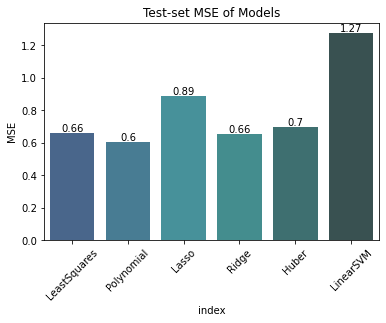

In [13]:
LinearMSE_bar = sns.barplot(data=LinearResult.reset_index(),x='index',y='MSE',palette="mako_d")
plt.title('Test-set MSE of Models')
for item in LinearMSE_bar.get_xticklabels():
    item.set_rotation(45)
for index,row in LinearResult.reset_index().iterrows():
    LinearMSE_bar.text(row.name,row.MSE+0.01,round(row.MSE,2),color='black',ha='center')
plt.show()

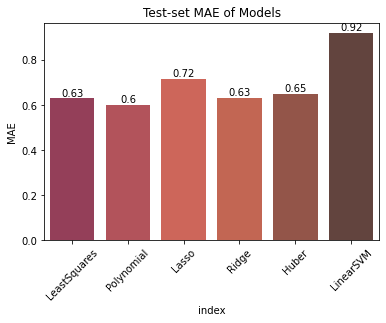

In [14]:
LinearMAE_bar = sns.barplot(data=LinearResult.reset_index(),x='index',y='MAE',palette="rocket_d")
plt.title('Test-set MAE of Models')
for item in LinearMAE_bar.get_xticklabels():
    item.set_rotation(45)
for index,row in LinearResult.reset_index().iterrows():
    LinearMAE_bar.text(row.name,row.MAE+0.01,round(row.MAE,2),color='black',ha='center')
plt.show()

In [15]:
TheRidge = LinearTrained[3]
RidgeCoef = TheRidge.trained_model.best_estimator_.coef_
RidgeIntercept = TheRidge.trained_model.best_estimator_.intercept_
RidgeResult = pd.DataFrame({'coef':RidgeCoef},index=df.columns[:-1])
RidgeResult.loc['intercept'] = {'coef':RidgeIntercept}
display(RidgeResult)

,coef
fixed acidity,0.053290
volatile acidity,-1.803330
citric acid,-0.019327
residual sugar,0.067865
chlorides,-0.914396
free sulfur dioxide,0.004810
total sulfur dioxide,-0.000553
density,-122.705381
pH,0.587308
sulphates,0.544642


In [16]:
TheLasso = LinearTrained[2]
LassoCoef = TheLasso.trained_model.best_estimator_.coef_
LassoIntercept = TheLasso.trained_model.best_estimator_.intercept_
LassoResult = pd.DataFrame({'coef':LassoCoef},index=df.columns[:-1])
LassoResult.loc['intercept'] = {'coef':LassoIntercept}
display(LassoResult)
display()

,coef
fixed acidity,-0.000000
volatile acidity,-0.000000
citric acid,-0.000000
residual sugar,-0.000000
chlorides,-0.000000
free sulfur dioxide,0.000000
total sulfur dioxide,-0.000000
density,-0.000000
pH,0.000000
sulphates,0.000000


Now consider the tree-based models.

In [17]:
TreeNames = []
TreeMSE = []
TreeMAE = []
TreeTrained = []

for iModel in TreeModels:
    TreeNames.append(iModel.name)
    iModel.train(y_train,X_train)
    pred = iModel.predict(y_test,X_test)
    TreeMSE.append(iModel.error_score(method='mse'))
    TreeMAE.append(iModel.error_score(method='mae'))
    TreeTrained.append(iModel)

TreeResult= pd.DataFrame({'MSE':TreeMSE,'MAE':TreeMAE},index=TreeNames)

In [18]:
display(TreeResult)

,MSE,MAE
DecisionTree,0.664709,0.640246
Bagging,0.528486,0.555034
RandomForest,0.525171,0.559043
GBDT,0.476952,0.492459
AdaBoost,0.488895,0.525041


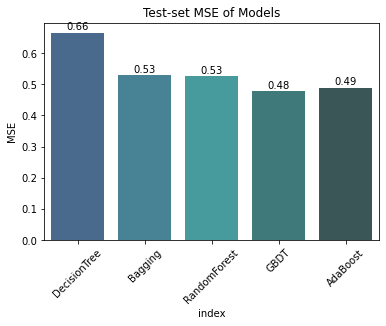

In [19]:
TreeMSE_bar = sns.barplot(data=TreeResult.reset_index(),x='index',y='MSE',palette="mako_d")
plt.title('Test-set MSE of Models')
for item in TreeMSE_bar.get_xticklabels():
    item.set_rotation(45)
for index,row in TreeResult.reset_index().iterrows():
    TreeMSE_bar.text(row.name,row.MSE+0.01,round(row.MSE,2),color='black',ha='center')
plt.show()

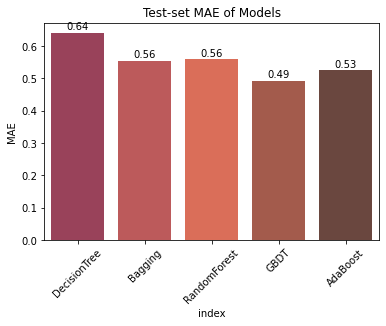

In [20]:
TreeMAE_bar = sns.barplot(data=TreeResult.reset_index(),x='index',y='MAE',palette='rocket_d')
plt.title('Test-set MAE of Models')
for item in TreeMAE_bar.get_xticklabels():
    item.set_rotation(45)
for index,row in TreeResult.reset_index().iterrows():
    TreeMAE_bar.text(row.name,row.MAE+0.01,round(row.MAE,2),color='black',ha='center')
plt.show()

[Text(167.4, 195.696, 'X[10] <= 10.85\nsquared_error = 0.759\nsamples = 3918\nvalue = 5.892'),
 Text(83.7, 152.208, 'X[1] <= 0.237\nsquared_error = 0.568\nsamples = 2461\nvalue = 5.618'),
 Text(41.85, 108.72, 'X[3] <= 12.75\nsquared_error = 0.567\nsamples = 900\nvalue = 5.966'),
 Text(20.925, 65.232, 'X[5] <= 15.5\nsquared_error = 0.506\nsamples = 681\nvalue = 5.89'),
 Text(10.4625, 21.744, 'squared_error = 0.711\nsamples = 46\nvalue = 5.37'),
 Text(31.387500000000003, 21.744, 'squared_error = 0.47\nsamples = 635\nvalue = 5.928'),
 Text(62.775000000000006, 65.232, 'X[1] <= 0.205\nsquared_error = 0.681\nsamples = 219\nvalue = 6.201'),
 Text(52.3125, 21.744, 'squared_error = 0.637\nsamples = 118\nvalue = 6.551'),
 Text(73.2375, 21.744, 'squared_error = 0.422\nsamples = 101\nvalue = 5.792'),
 Text(125.55000000000001, 108.72, 'X[1] <= 0.297\nsquared_error = 0.46\nsamples = 1561\nvalue = 5.418'),
 Text(104.625, 65.232, 'X[10] <= 9.85\nsquared_error = 0.499\nsamples = 741\nvalue = 5.584'),
 

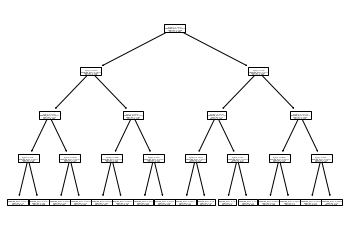

In [21]:
TheDT = TreeTrained[0].trained_model.best_estimator_
tree.plot_tree(TheDT)

In [22]:
TheGBDT = TreeTrained[-2].trained_model.best_estimator_
feature_impt = TheGBDT.feature_importances_
impt_df = pd.DataFrame({'importance':feature_impt},index=df.columns[:-1])
display(impt_df)

,importance
fixed acidity,0.055916
volatile acidity,0.128907
citric acid,0.054830
residual sugar,0.066957
chlorides,0.066032
free sulfur dioxide,0.109813
total sulfur dioxide,0.065141
density,0.065670
pH,0.070103
sulphates,0.058185


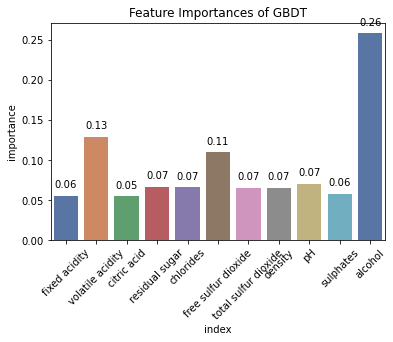

In [23]:
TreeImpt_bar = sns.barplot(data=impt_df.reset_index(),x='index',y='importance',palette='deep')
plt.title('Feature Importances of GBDT')
for item in TreeImpt_bar.get_xticklabels():
    item.set_rotation(45)
for index,row in impt_df.reset_index().iterrows():
    TreeImpt_bar.text(row.name,row.importance+0.01,round(row.importance,2),color='black',ha='center')
plt.show()

Finally we test the performance of other machine learning models.

In [24]:
OtherNames = []
OtherMSE = []
OtherMAE = []
OtherTrained = []

for iModel in OtherModels:
    OtherNames.append(iModel.name)
    iModel.train(y_train,X_train)
    pred = iModel.predict(y_test,X_test)
    OtherMSE.append(iModel.error_score(method='mse'))
    OtherMAE.append(iModel.error_score(method='mae'))
    OtherTrained.append(iModel)

OtherResult= pd.DataFrame({'MSE':OtherMSE,'MAE':OtherMAE},index=OtherNames)

In [25]:
OtherResult

,MSE,MAE
KNearestNeighbors,0.585929,0.582347
GaussianSVM,0.645276,0.638707
GaussianProcess,16.277748,3.212542


4 Optimization
==============

In [26]:
# Please install the following package before running the code in this part.
from cvxopt.solvers import coneqp,qp
from cvxopt import matrix
from cvxopt.lapack import potrf
from scipy import optimize
from sko.DE import DE

First, we attempt to optimize polynomial regression model with degree 2. This is also called "response surface" optimization. The objective function of this model is a nonconvex quadratic function, and we used successive convex approximation (SCA) algorithm to solve it.

The nonconvex optimization problem:  
\begin{array}
\ \min{} \frac{1}{2}x^T P x + q^T x \\
s.t. lb\le x \le ub
\end{array}
where $P$ is not positive semidefinite.
SCA Algorithm:  
1. Decompose $P$ based on the signs of its eigenvalues:
\begin{equation}P=H^T diag(\lambda_k) H=H^T diag(\lambda_k^{+}) H-H^T diag(-\lambda_k^{-}) H=M-N\end{equation}
where each eigenvalue is decomposed to $\lambda_k = max(\lambda_k,0)-max(-\lambda_k,0)=\lambda_k^{+}-(-\lambda_k^{-})$.  
2. Initialize $x_0\in [lb,ub]$, $\epsilon >0$, $k=0$
3. Solve convex quadratic programming problem:
\begin{array}
\ \min{} \frac{1}{2}x^T M x + q^T x - (x^k)^T N x \\
s.t. lb\le x \le ub
\end{array}
and obtain the solution $x^{k+1}$
4. Terminate if $|x^{k+1}-x^k|\le \epsilon$, otherwise $k\leftarrow k+1$ and return to step 3.

In the above algorithm, We first decomposite $\frac{1}{2} x^T P x$ to $\frac{1}{2} x^T M x$ and $\frac{1}{2} x^T N x$. Since $M$ is positive semidefinite, $\frac{1}{2} x^T M x$ becomes a convex function. Then, we approximate $\frac{1}{2} x^T N x$ with first-order Taylor expansion: $\frac{1}{2}x_k^T N x_k+x_k^T N x$ so that $-\frac{1}{2} x^T N x$ also becomes a convex function. Thus, this problem is reduced to a convex quadratic programming.

In [38]:
def sca_qp(P,q,x0,lb,ub,tol):
    """
    Solve nonconvex quadratic programming problem with successive convex approximation algorithm.
    The algorithm attempts to minimize (1/2)*(x^T)Px+(q^T)x with constraints x>=lb and x<=ub.
    :param P: (n,n) array, the quadratic coefficients of the objective
    :param q: (n,1) array, the linear coefficients of the objective 
    :param x0: (n,1) array, initial data points for optimization
    :param lb: (n,1) array, lower bounds
    :param ub: (n,1) array, upper bounds
    :tol: (n,1) array, tolerence for termination
    """
    # Eigenvalue decomposition
    eig_vals,eig_vecs = np.linalg.eig(P)
    M = eig_vecs.dot(np.diag(np.array([(i if i>0 else 0) for i in eig_vals]))).dot(eig_vecs.T)
    N = eig_vecs.dot(np.diag(np.array([(-i if i<0 else 0) for i in eig_vals]))).dot(eig_vecs.T)
    
    # Construct linear constrints
    d = P.shape[0]
    G = np.vstack([np.identity(d),-np.identity(d)])
    h = np.vstack([ub,-lb])
    
    # Iteration
    x = x0.copy(); last_x = x+2*tol;
    while ((np.abs(x-last_x)>tol).all()):
        last_x = x.copy()
        c = q - (np.dot(x.T,N)).T
        opt_res = qp(matrix(M),matrix(c),matrix(G),matrix(h))
        x = np.array(opt_res['x'])
    return x
    

In [44]:
n_feat = len(df.columns[:-1]) # number of features
lb = df.loc[:,:'alcohol'].quantile(0.1).values.reshape(-1,1) # lower bounds of features
ub = df.loc[:,:'alcohol'].quantile(0.9).values.reshape(-1,1) # upper bounds of features
x0 = df.loc[:,:'alcohol'].mean().values.reshape(-1,1) # Initial points
tol = (ub-lb)*0.00001
poly_coef = LinearTrained[1].trained_model.coef_
poly_intercept = poly_coef[0]

# Generate objective function for optimization
q = -poly_coef[1:1+n_feat].reshape(-1,1)
P = np.empty((n_feat,n_feat))
cursor = 1+n_feat
for i_feat in range(n_feat):
    for j_feat in range(n_feat):
        if j_feat<i_feat:
            P[i_feat,j_feat] = P[j_feat,i_feat]
        elif i_feat==j_feat:
            P[i_feat,j_feat] = poly_coef[cursor]
            cursor+=1
        else:
            P[i_feat,j_feat] = poly_coef[cursor]*0.5
            cursor+=1
P = -2*P

opt_x = sca_qp(P,q,x0,lb,ub,tol)
opt_df = pd.DataFrame({'lb':lb.reshape(-1),'ub':ub.reshape(-1),'opt_x':opt_x.reshape(-1)},index=df.columns[:-1])
display(opt_df)
print('Optimal score:',(opt_x.T.dot(-0.5*P).dot(opt_x)-q.T.dot(opt_x)+poly_intercept)[0,0])

     pcost       dcost       gap    pres   dres
 0: -1.4630e+04 -7.7097e+03  1e+05  2e+00  7e-16
 1: -5.0921e+01 -4.4574e+03  6e+03  2e-02  8e-15
 2:  9.7229e+01 -1.1394e+02  2e+02  2e-04  1e-14
 3:  9.8650e+01  9.3920e+01  5e+00  4e-06  9e-16
 4:  9.8336e+01  9.7313e+01  1e+00  8e-07  7e-16
 5:  9.7952e+01  9.7685e+01  3e-01  7e-08  2e-16
 6:  9.7899e+01  9.7871e+01  3e-02  7e-09  2e-16
 7:  9.7890e+01  9.7889e+01  6e-04  1e-10  2e-16
 8:  9.7890e+01  9.7890e+01  6e-06  1e-12  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8416e+04 -2.6450e+04  8e+05  4e+00  1e-15
 1: -4.8884e+02 -1.9048e+04  3e+04  4e-02  2e-14
 2:  2.9613e+02 -6.6115e+02  1e+03  5e-04  7e-15
 3:  3.0317e+02  2.8007e+02  2e+01  8e-06  3e-16
 4:  3.0173e+02  2.9836e+02  3e+00  8e-07  1e-15
 5:  3.0011e+02  2.9951e+02  6e-01  6e-08  2e-16
 6:  2.9988e+02  2.9986e+02  2e-02  1e-09  6e-16
 7:  2.9987e+02  2.9987e+02  1e-03  2e-11  4e-16
 8:  2.9987e+02  2.9987e+02  8e-05  2e-15  3e-1

,lb,ub,opt_x
fixed acidity,5.900000,7.90000,7.899999
volatile acidity,0.170000,0.40000,0.170000
citric acid,0.220000,0.49000,0.490000
residual sugar,1.200000,14.00000,13.990166
chlorides,0.030000,0.05800,0.030000
free sulfur dioxide,15.000000,57.00000,36.081107
total sulfur dioxide,87.000000,195.00000,116.141843
density,0.990327,0.99815,0.990327
pH,3.000000,3.38000,3.380000
sulphates,0.360000,0.64000,0.640000


Optimal score: 10.177835924079773


Now we consider optimizing the GBDT model.

In [48]:
GBDT_func = lambda x: -TheGBDT.predict(x.reshape(-1,11))[0]
def testfunc(x):
    print(x)
    return np.sum(x)
print(GBDT_func(df.loc[:,:'alcohol'].mean().values))
de = DE(func=GBDT_func,n_dim=11,lb=lb.reshape(-1),ub=ub.reshape(-1),max_iter=1000)
opt_x,opt_y = de.run()
print('opt_x:',opt_x)
print('opt_y:',-opt_y)
opt_df = pd.DataFrame({'lb':lb.reshape(-1),'ub':ub.reshape(-1),'opt_x':opt_x},index=df.columns[:-1])
display(opt_df)

-5.8198094460084855
opt_x: [7.05511072e+00 2.57542698e-01 4.84539044e-01 9.15961239e+00
 3.08751579e-02 5.61460743e+01 1.27801992e+02 9.91389700e-01
 3.37594597e+00 4.78949760e-01 1.23708585e+01]
opt_y: [9.0923755]


,lb,ub,opt_x
fixed acidity,5.900000,7.90000,7.055111
volatile acidity,0.170000,0.40000,0.257543
citric acid,0.220000,0.49000,0.484539
residual sugar,1.200000,14.00000,9.159612
chlorides,0.030000,0.05800,0.030875
free sulfur dioxide,15.000000,57.00000,56.146074
total sulfur dioxide,87.000000,195.00000,127.801992
density,0.990327,0.99815,0.991390
pH,3.000000,3.38000,3.375946
sulphates,0.360000,0.64000,0.478950
